In [ ]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score
)
import kagglehub

# Suppress warnings
warnings.filterwarnings('ignore')

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline


In [ ]:
#Loading data


# Download latest version
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

train_path = os.path.join(path, 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
test_path = os.path.join(path, 'diabetes_binary_health_indicators_BRFSS2015.csv')

100%|██████████| 6.03M/6.03M [00:00<00:00, 64.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alexteboul/diabetes-health-indicators-dataset/versions/1
['diabetes_binary_5050split_health_indicators_BRFSS2015.csv', 'diabetes_binary_health_indicators_BRFSS2015.csv', 'diabetes_012_health_indicators_BRFSS2015.csv']


In [ ]:
df= pd.read_csv(train_path)

In [ ]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [ ]:
df.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [ ]:
numeric_columns = ['BMI' , 'Age' , 'Income' , 'MentHlth', 'PhysHlth' , 'GenHlth' , 'Education']

for column_name in numeric_columns:
    Q1 = np.percentile(df[column_name], 25, interpolation='midpoint')
    Q3 = np.percentile(df[column_name], 75, interpolation='midpoint')

    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR

    # Find outliers in the specified column
    outliers = df[(df[column_name] < low_lim) | (df[column_name] > up_lim)][column_name]

    # Replace outliers with the respective lower or upper limit
    df[column_name] = np.where(df[column_name] < low_lim, low_lim, df[column_name])
    df[column_name] = np.where(df[column_name] > up_lim, up_lim, df[column_name])

In [ ]:
X = df.drop('Diabetes_binary', axis = 1)
y = df['Diabetes_binary']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20)

In [ ]:
log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=200)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=200, solver='liblinear')

Accuracy: 74.88%
F1 Score: 75.35%
Testing
Accuracy: 75.39%
F1 Score: 75.95%


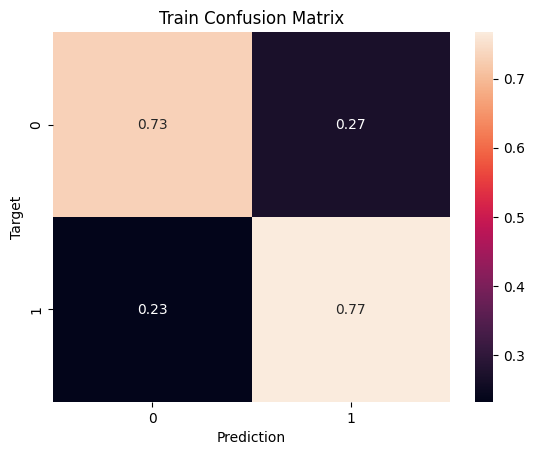

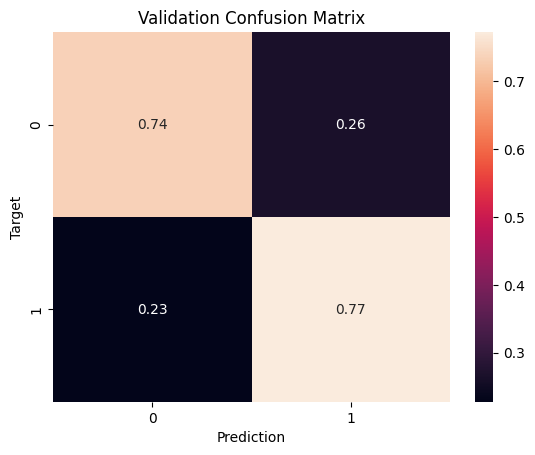

In [ ]:
def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    f1_score_ = f1_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("F1 Score: {:.2f}%".format(f1_score_ * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))

    return preds

# Predict and plot on the training data
train_preds = predict_and_plot(log_reg, X_train, y_train, 'Train')
print('Testing')
# Predict and plot on the validation data
val_preds = predict_and_plot(log_reg, X_test, y_test, 'Validation')


In [ ]:
model_2 = RandomForestClassifier(n_jobs =-1, random_state = 42)
model_2.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
model_2.score(X_train,y_train)

0.9949251144943682

Accuracy: 99.47%
F1 Score: 99.47%
Testing:
Accuracy: 73.85%
F1 Score: 74.89%


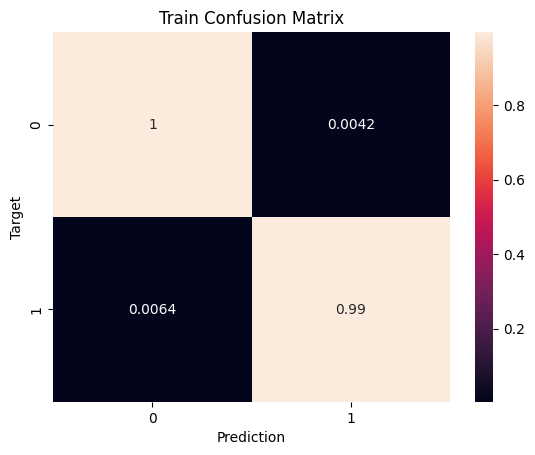

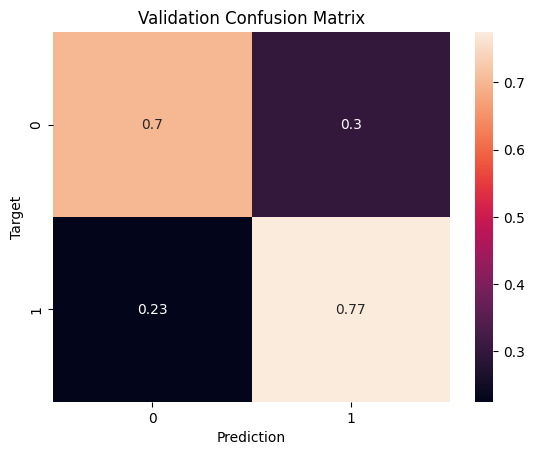

In [ ]:
train_preds = predict_and_plot(model_2, X_train, y_train, 'Train')
print('Testing:')
# Predict and plot on the validation data
val_preds = predict_and_plot(model_2, X_test, y_test, 'Validation')


In [ ]:
param_grid = {
    'n_estimators': [10, 20, 30],  # Adjust the number of trees in the forest
    'max_depth': [10, 20, 30],  # Adjust the maximum depth of each tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Adjust the minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6, 8]  # Adjust the minimum samples required in a leaf node
}

model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the training and validation data
train_accuracy = best_model.score(X_train, y_train)
val_accuracy = best_model.score(X_test, y_test)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)



Training Accuracy: 0.7674217106077484
Validation Accuracy: 0.7494872338920716


In [ ]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=15,
                       n_estimators=30, n_jobs=-1, random_state=42)

Accuracy: 79.67%
F1 Score: 80.11%
Testing
Accuracy: 70.82%
F1 Score: 71.41%


array([1., 1., 0., ..., 0., 0., 1.])

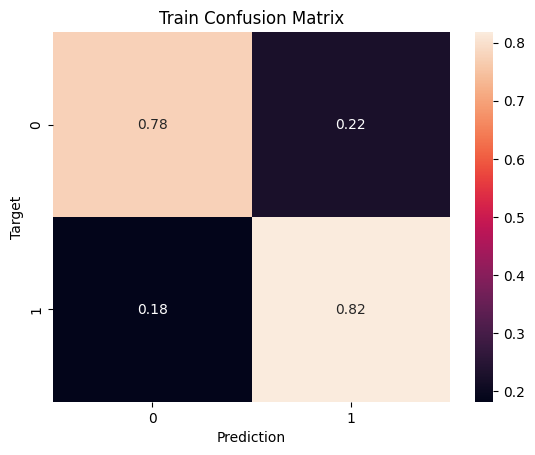

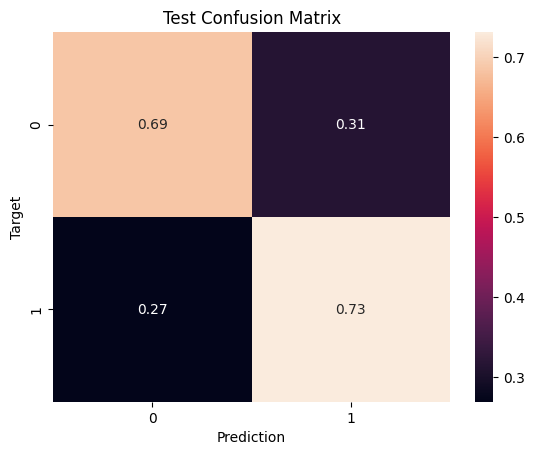

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

# y_train_pred = knn_model.predict(X_train)

# y_val_pred = knn_model.predict(X_val)

predict_and_plot(knn_model, X_train, y_train, 'Train')
print('Testing')
predict_and_plot(knn_model, X_val, y_val, 'Test')
# train_accuracy = accuracy_score(y_train, y_train_pred)
# val_accuracy = accuracy_score(y_val, y_val_pred)

# print("Training Accuracy:", train_accuracy)
# print("Validation Accuracy:", val_accuracy)

# confusion = confusion_matrix(y_val, y_val_pred)

# plt.figure(figsize=(6, 4))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix (Validation)')
# plt.show()


Training Accuracy: 0.7491910243488409
Validation Accuracy: 0.7501944974892142


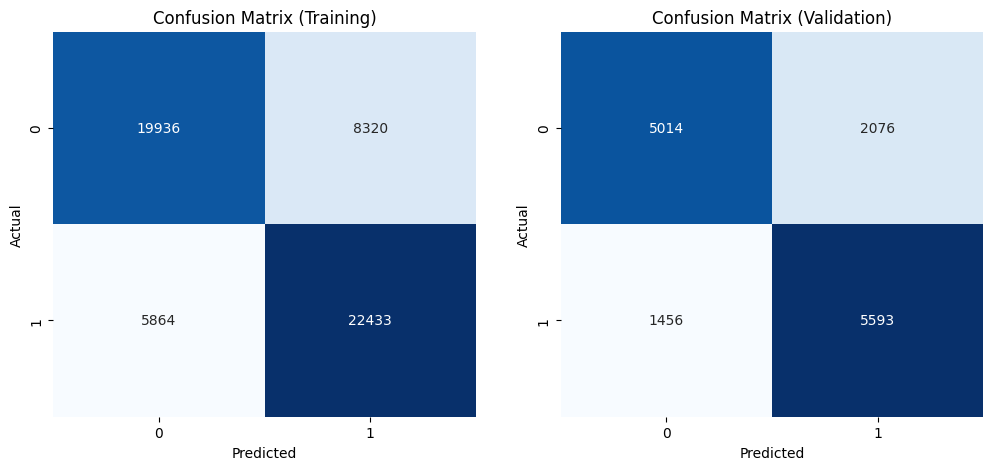

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

y_train_pred = svm_model.predict(X_train)

y_val_pred = svm_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)

val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

train_confusion = confusion_matrix(y_train, y_train_pred)
val_confusion = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training)')

plt.subplot(1, 2, 2)
sns.heatmap(val_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation)')
plt.show()


In [ ]:

# Create a Gradient Boosting classifier
gbm_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)

# Fit the GBM model to the training data
gbm_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred_gbm = gbm_model.predict(X_train)

# Make predictions on the validation data
y_val_pred_gbm = gbm_model.predict(X_val)

# Calculate the training accuracy
train_accuracy_gbm = accuracy_score(y_train, y_train_pred_gbm)

# Calculate the validation accuracy
val_accuracy_gbm = accuracy_score(y_val, y_val_pred_gbm)

# Print the training and validation accuracies
print("GBM Training Accuracy:", train_accuracy_gbm)
print("GBM Validation Accuracy:", val_accuracy_gbm)


GBM Training Accuracy: 0.7552384488886531
GBM Validation Accuracy: 0.7542258999929273


In [ ]:

# Create an XGBoost classifier
xgboost_model = XGBClassifier(n_estimators=100, max_depth=3, random_state=42)

# Fit the XGBoost model to the training data
xgboost_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred_xgboost = xgboost_model.predict(X_train)

# Make predictions on the validation data
y_val_pred_xgboost = xgboost_model.predict(X_val)

# Calculate the training accuracy
train_accuracy_xgboost = accuracy_score(y_train, y_train_pred_xgboost)

# Calculate the validation accuracy
val_accuracy_xgboost = accuracy_score(y_val, y_val_pred_xgboost)

# Print the training and validation accuracies
print("XGBoost Training Accuracy:", train_accuracy_xgboost)
print("XGBoost Validation Accuracy:", val_accuracy_xgboost)


XGBoost Training Accuracy: 0.7573426697080614
XGBoost Validation Accuracy: 0.7553575217483556


AdaBoost Training Accuracy: 0.7501635633830213
AdaBoost Validation Accuracy: 0.7524577410000707


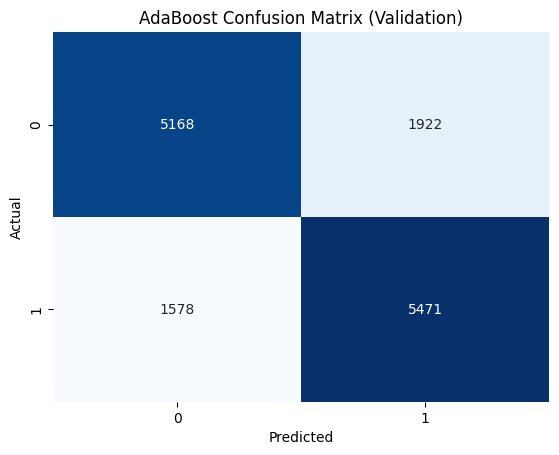

In [ ]:



adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)

adaboost_model.fit(X_train, y_train)

y_train_pred_adaboost = adaboost_model.predict(X_train)

y_val_pred_adaboost = adaboost_model.predict(X_val)

train_accuracy_adaboost = accuracy_score(y_train, y_train_pred_adaboost)

val_accuracy_adaboost = accuracy_score(y_val, y_val_pred_adaboost)

print("AdaBoost Training Accuracy:", train_accuracy_adaboost)
print("AdaBoost Validation Accuracy:", val_accuracy_adaboost)

confusion_adaboost = confusion_matrix(y_val, y_val_pred_adaboost)

# Plot the confusion matrix
plt.figure()
sns.heatmap(confusion_adaboost, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('AdaBoost Confusion Matrix (Validation)')
plt.show()


In [ ]:


param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 3, 5, 7],
    'criterion': ['gini', 'entropy']  # Add criterion hyperparameter
}

decision_tree_model = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

train_accuracy = best_model.score(X_train, y_train)
val_accuracy = best_model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)



Training Accuracy: 0.7618340317931852
Validation Accuracy: 0.751467571964071


## Trying out various data transforming techniques:  
1. Random Smapling
2. CUR
3. PCA

In [ ]:


#Helper function that tries the best models on the given data
def train_test_models(X_train,
                      y_train,
                      X_test,
                      y_test):
  #Logistic Regression
  log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=200)
  log_reg.fit(X_train, y_train)
  #Random Forest with best parameters
  model_2 = RandomForestClassifier(max_depth = 10,
                                   min_samples_split = 15,
                                   n_estimators = 30,
                                   n_jobs = -1,
                                   random_state = 42)
  model_2.fit(X_train,y_train)
  #XGBoost
  # Create an XGBoost classifier
  xgboost_model = XGBClassifier(n_estimators=100, max_depth=3, random_state=42)
  # Fit the XGBoost model to the training data
  xgboost_model.fit(X_train, y_train)

  summary = {}
  models = [('Logistic_Regression', log_reg), ('RandomForest', model_2), ('XGBoost', xgboost_model)]

  for model in tqdm(models):
    y_train_pred = model[1].predict(X_train)
    y_test_pred = model[1].predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    confusion_mat = confusion_matrix(y_test, y_test_pred)


    summary[model[0]] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'confusion_matrix': confusion_mat,
        'f1_score_train': train_f1,
        'f1_score_test': test_f1
    }

  return summary


def summary_print(summary):
  for i in summary.keys():
    print(f'For model {i}')
    print(f"Train Accuracy: {summary[i]['train_accuracy']}")
    print(f"Test Accuracy: {summary[i]['test_accuracy']}")
    print(f"Train F1 Score: {summary[i]['f1_score_train']}")
    print(f"Test F1 Score: {summary[i]['f1_score_test']}")
    print(f'')
    #Confusion matrix
    plt.figure()
    sns.heatmap(summary[i]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{i} Confusion Matrix (Test)')
    plt.show()


In [ ]:
train_test_models(X_train, y_train, X_test, y_test)

100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


{'Logistic_Regression': {'train_accuracy': 0.749668452601984,
  'test_accuracy': 0.7534479100360705,
  'confusion_matrix': array([[5141, 1883],
         [1603, 5512]]),
  'f1_score_train': 0.7548528978856777,
  'f1_score_test': 0.7597518952446588},
 'RandomForest': {'train_accuracy': 0.7690485031740137,
  'test_accuracy': 0.7693613409717802,
  'confusion_matrix': array([[5092, 1932],
         [1329, 5786]]),
  'f1_score_train': 0.7788407809404474,
  'f1_score_test': 0.7801523629744489},
 'XGBoost': {'train_accuracy': 0.7573426697080614,
  'test_accuracy': 0.760520546007497,
  'confusion_matrix': array([[5015, 2009],
         [1377, 5738]]),
  'f1_score_train': 0.7680946345585129,
  'f1_score_test': 0.7721706365226753}}

## PCA

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
pca = PCA(n_components=10) #selecting top 10 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_summary = train_test_models(X_train_pca, y_train, X_test_pca, y_test)

100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


For model Logistic_Regression
Train Accuracy: 0.7430375046416636
Test Accuracy: 0.7463752740646439
Train F1 Score: 0.7473398706446902
Test F1 Score: 0.751455503188245



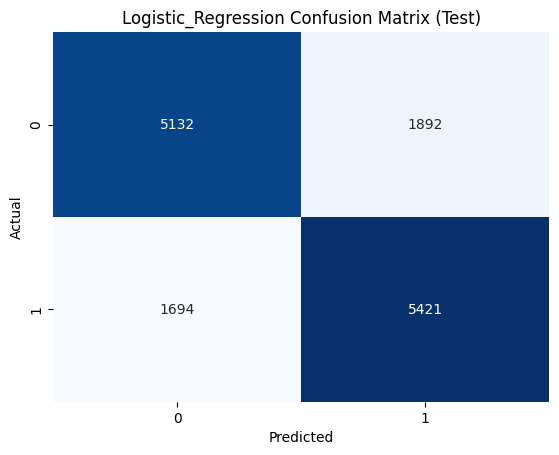

For model RandomForest
Train Accuracy: 0.7748660548512015
Test Accuracy: 0.7723318480797793
Train F1 Score: 0.7865119554646366
Test F1 Score: 0.784523729834661



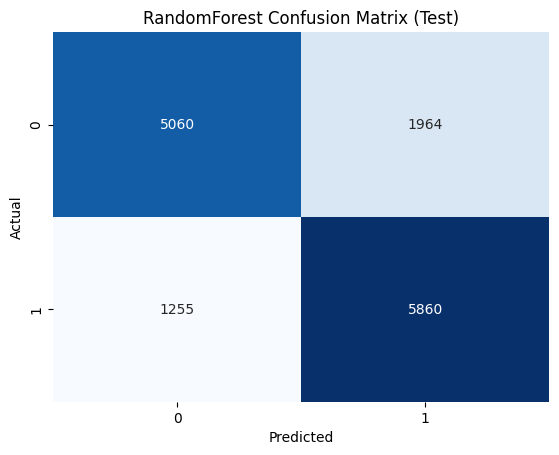

For model XGBoost
Train Accuracy: 0.7558750198928439
Test Accuracy: 0.7572671334606408
Train F1 Score: 0.7663564054831613
Test F1 Score: 0.7685147713476326



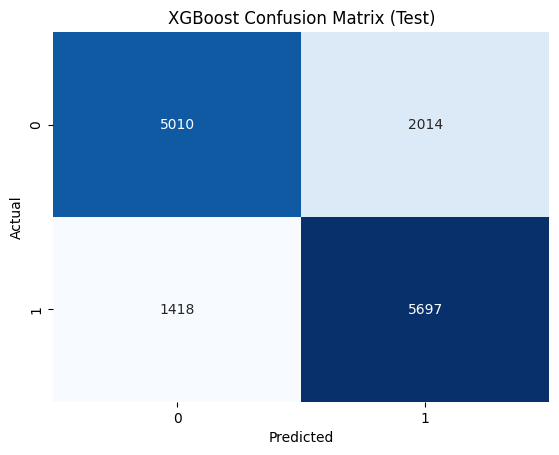

In [ ]:
summary_print(pca_summary)

## CUR

In [ ]:
def cur_decomposition(A, rank):
    """
    Perform CUR decomposition on a matrix or DataFrame A.

    Parameters:
        A (array-like): Input data matrix (m x n), can be a NumPy array or Pandas DataFrame.
        rank (int): Number of columns and rows to select for approximation.

    Returns:
        C (array-like): Selected columns matrix (m x k).
        U (array-like): Core matrix (k x k).
        R (array-like): Selected rows matrix (k x n).
    """

    is_dataframe = isinstance(A, pd.DataFrame)

    # Step 1: Column selection (C)
    col_norms = np.linalg.norm(A.values if is_dataframe else A, axis=0) ** 2
    col_prob = col_norms / np.sum(col_norms)
    col_indices = np.random.choice(A.shape[1], size=rank, replace=False, p=col_prob)
    C = A.iloc[:, col_indices] if is_dataframe else A[:, col_indices]

    # Step 2: Row selection (R)
    row_norms = np.linalg.norm(A.values if is_dataframe else A, axis=1) ** 2
    row_prob = row_norms / np.sum(row_norms)
    row_indices = np.random.choice(A.shape[0], size=rank, replace=False, p=row_prob)
    R = A.iloc[row_indices, :] if is_dataframe else A[row_indices, :]

    # Step 3: Compute core matrix (U)
    W = A.iloc[row_indices, col_indices] if is_dataframe else A[np.ix_(row_indices, col_indices)]
    U = np.linalg.pinv(W.values if is_dataframe else W)

    return C, U, R


rank = 10  # Number of rows/columns to retain
C, U, R = cur_decomposition(X_train, rank)

# Approximate X_train using CUR
X_train_approx = np.dot(np.dot(C, U), R)

# For X_test, use the same selected columns (C) and rows (R)
X_test_approx = np.dot(np.dot(X_test[C.columns], U), R)



In [ ]:
summary_cur = train_test_models(X_train_approx, y_train, X_test_approx, y_test)

100%|██████████| 3/3 [00:00<00:00,  6.11it/s]


For model Logistic_Regression
Train Accuracy: 0.7299877990557531
Test Accuracy: 0.7329372657189335
Train F1 Score: 0.7335543535159658
Test F1 Score: 0.7369007803790413



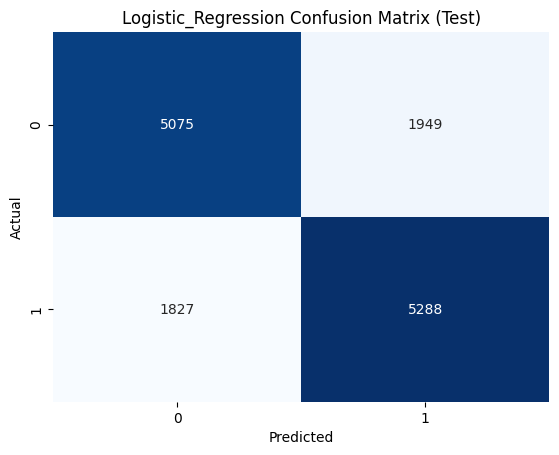

For model RandomForest
Train Accuracy: 0.7624706027973759
Test Accuracy: 0.7543673527123559
Train F1 Score: 0.7750104681349971
Test F1 Score: 0.7683276632646254



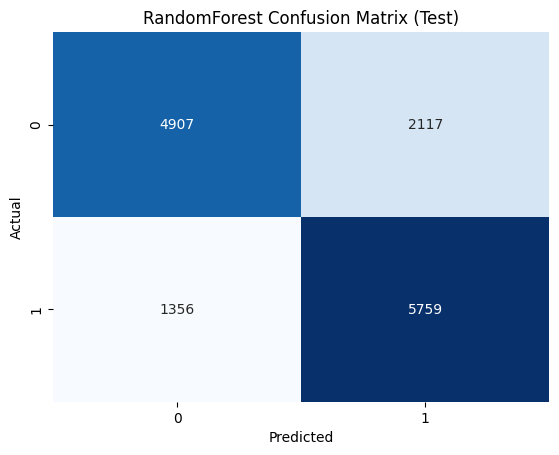

For model XGBoost
Train Accuracy: 0.7434972503669125
Test Accuracy: 0.74000990169036
Train F1 Score: 0.7562672222595604
Test F1 Score: 0.7537843268586738



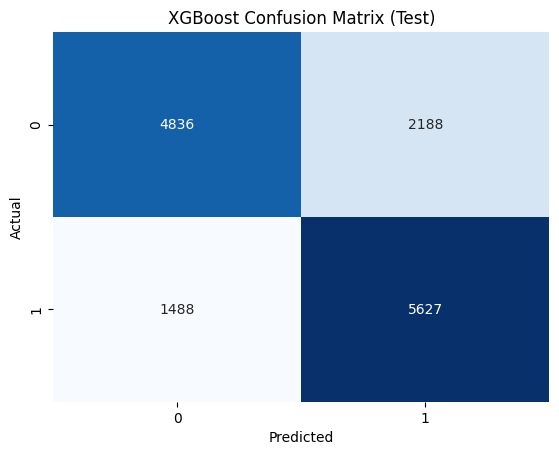

In [ ]:
summary_print(summary_cur)

# Random Sampling (Simpler Technique)

In [ ]:
def random_sampling_with_core(A, num_rows, num_columns):
    """
    Perform random sampling with a core matrix for matrix approximation.

    Parameters:
        A (array-like): Input matrix (m x n), can be a NumPy array or Pandas DataFrame.
        num_rows (int): Number of rows to sample.
        num_columns (int): Number of columns to sample.

    Returns:
        C (array-like): Selected columns matrix (m x k).
        U (array-like): Core matrix (k x k).
        R (array-like): Selected rows matrix (k x n).
    """
    is_dataframe = isinstance(A, pd.DataFrame)

    # Step 1: Randomly sample rows and columns
    row_indices = np.random.choice(A.shape[0], size=num_rows, replace=False)
    col_indices = np.random.choice(A.shape[1], size=num_columns, replace=False)

    C = A.iloc[:, col_indices] if is_dataframe else A[:, col_indices]
    R = A.iloc[row_indices, :] if is_dataframe else A[row_indices, :]

    # Step 2: Compute core matrix (U) using the intersection of sampled rows and columns
    W = A.iloc[row_indices, col_indices] if is_dataframe else A[np.ix_(row_indices, col_indices)]
    U = np.linalg.pinv(W.values if is_dataframe else W)

    return C, U, R


In [ ]:
num_rows = 100  # Number of rows to sample
num_columns = 10  # Number of columns to sample

C, U, R = random_sampling_with_core(X_train, num_rows, num_columns)

# Approximate the training set
X_train_approx = np.dot(np.dot(C, U), R)


In [ ]:
summary_random = train_test_models(X_train_approx, y_train, X_test, y_test)

100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


For model Logistic_Regression
Train Accuracy: 0.7031103566565876
Test Accuracy: 0.6729613126812363
Train F1 Score: 0.7173495841890846
Test F1 Score: 0.665992487720312



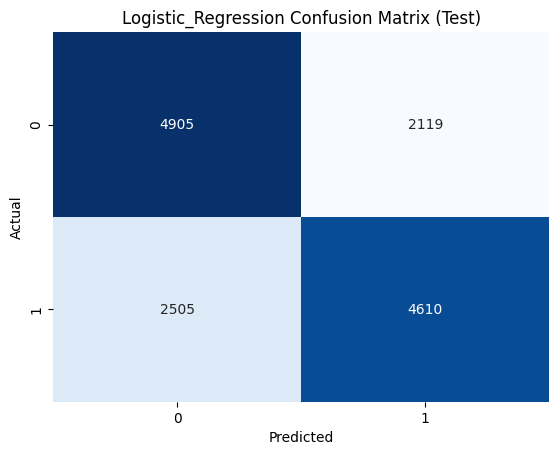

For model RandomForest
Train Accuracy: 0.7150460629851644
Test Accuracy: 0.6946743051135158
Train F1 Score: 0.7327573340408948
Test F1 Score: 0.6617566402883335



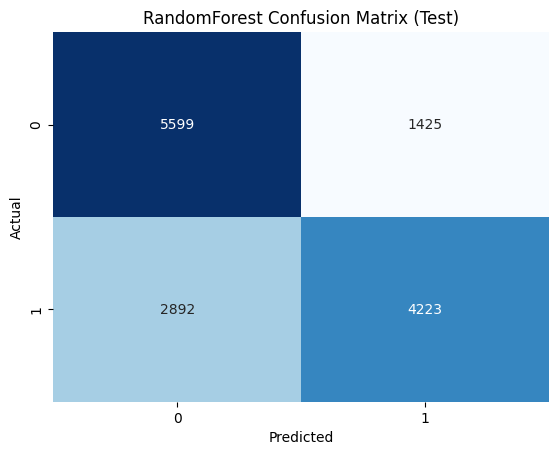

For model XGBoost
Train Accuracy: 0.71143882729475
Test Accuracy: 0.6822264658038051
Train F1 Score: 0.7281480617701445
Test F1 Score: 0.6499415660303857



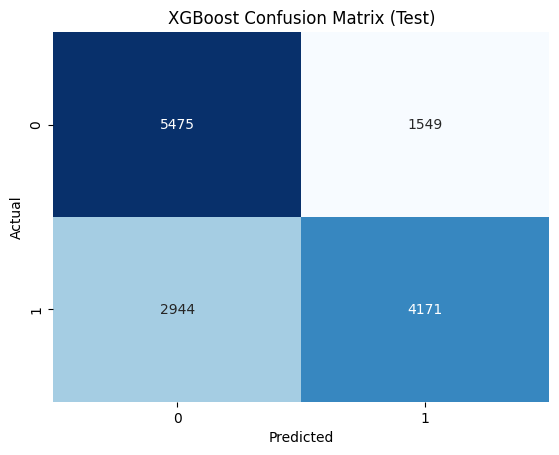

In [ ]:
summary_print(summary_random)